# 2022년 제2회 K-인공지능 제조데이터 분석 경진대회<br>
## 용해탱크 장비이상 조기탐지
## MM3조
### 조장: 황성하
### 조원: 김연수, 황한용

### 라이브러리 import/설명

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix
    , precision_score
    , recall_score
    , f1_score
    , accuracy_score
)

from keras.models import Sequential
from keras.optimizers import Nadam
from keras.layers import Dense, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from scipy.special import erf
import scipy.stats


분석을 시작하기 위해서 분석에 사용할 라이브러리들을 불러오는 과정이 필요하다. <br>
코드길이의 단축화를 위해 `import package as A` 약어형태의 import가 있다. <br> 

라이브러리 설명은 아래와 같다.
- `Pandas`는 데이터 분석 시 가장 많이 쓰는 패키지로,<br>
표 데이터를 다루기 위한 시리즈(Series) 클래스와 데이터프레임(DataFrame) 클래스를 제공한다.
 
- `numpy`는 과학 계산을 위한 라이브러리로 다차원 배열을 처리하는데 여러 유용한 기능을 제공한다.<br>

- `matplotlib`는 자료를 차트(chart)나 플롯(plot)으로 시각화(visualization)하는 패키지이다.<br>
코드에서 `matplotlib.pyplot`은 `matplotlib`에서 지원하는 모듈 중 하나인 `pyplot`에 접근하여 불러온다는 것을 의미한다. <br>
`pyplot`의 인터페이스는 겉으로 드러나지 않으면서 자동으로 figure와 axes를 생성하며, 정의된 플롯을 얻을 수 있도록 만들어준다. <br>

- `%matplotlib inline`은 플롯 결과를 notebook문서에 저장하여 notebook을 실행한 브라우저에서<br>
바로 그림을 볼 수 있게 해주는 기능으로 Jupyter Notebook에서 사용한다.<br>
해당 선언을 해주면 다음번에 열었을 때 코드를 실행하지 않고도 그래프가 저장되어 유용하다.<br>

- `sklearn`은 데이터 과학 연산의 핵심 패키지로 다음을 지원한다.
    - 데이터 전처리: `preprocessing`, `train_test_split`
    - 지도 및 비지도 학습: 사용안함
    - 모델 선택: 사용안함
    - 검증 및 오차: `confusion_matrix`, `precision_score`, `recall_score`, `f1_score`, `accuracy_score`<br>
    `negative positive value(npv)`는 지원하지 않아 직접 계산하였다.<br>
<br>
- `keras`은 파이썬 기반 딥러닝 라이브러리로, 처음 딥러닝을 시작하는 사용자에게<br> 
편리하고 직관적인 API이며 다음을 지원한다.<br>
    - 모델 레이어 구성: `Sequential`, `Dense`, `GRU`
    - 학습 옵티마이저: `Nadam`
    - 학습 중 콜백: `EarlyStopping`, `ModelCheckpoint`

**!주의**<br>
만약 에러가 나는 경우는 해당 라이브러리가 설치가 안 돼서 발생하는 것이기 때문에<br>
에러가 나는 라이브러리를 아래와 같이 `!pip install`을 통해 설치해야 한다.<br>
> 예시) !pip install pandas


### 데이터 로드 / 분석

In [2]:
DATA_PATH = "../data/data.csv"
df = pd.read_csv(DATA_PATH)

데이터를 불러올 때, 데이터가 저장되어 있는 위치가 동일하다면 바로 불러오기를 해도 되지만<br>
다른 폴더에 저장되어 있다면 `DATA_PATH`를 지정해주어야 한다.<br>
또다른 파일경로 지정은 직접 `read_csv()`에 경로를 입력하는 방법이 있다.<br>
만약 위치를 상대경로로 하고싶은 경우에는 `os`라이브러리를 사용하면 된다. <br>
관련 링크는 아래와 같다.<br>
[os 라이브러리 공식문서](https://docs.python.org/ko/3.9/library/os.path.html)
<br><br>
여기서 주의할 점은 경로를 나타낼 때 구분자로 `/` 혹은 `\\`로 표시해야 한다는 것이다.<br>
하지만 `linux` 기반의 운영체제(`mac`, `centos`, `redhat` 등)와 윈도우 기반 운영체제 모두<br>
`/`을 지원하기 때문에 `/`을 사용하는 편이 좋다.<br><br>
csv 파일을 불러올 때는 `pandas`의 `read_csv("파일경로")` 명령어를 활용한다.<br>
불러올 때 encoding이 제대로 되지 않는다면 오류가 발생할 수 있으므로 지정해주어야 하지만<br>
기본 `encoding`이 한글을 지원하는 `utf-8`으로 설정되어있으므로 생략해도 무방하다. <br>
관련내용의 공식문서의 링크는 아래와 같다. <br>
[DataFrame.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [3]:
df.head(11)

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
5,2020-03-04 0:00,5,743,1722,603,3.21,OK
6,2020-03-04 0:00,6,390,212,602,3.19,OK
7,2020-03-04 0:00,7,493,152,600,3.19,OK
8,2020-03-04 0:00,8,427,0,599,3.19,OK
9,2020-03-04 0:00,9,489,148,598,3.20,OK


위의 결과를 보면 알 수 있듯이 똑같은 시간에 10개의 행이 존재하며<br>
11번째 행의 `STD_DT`는 이전 10번째 열의 `STD_DT`에 1분정도 경과한 것을 볼 수 있다.<br>
즉 한 행은 60초 / 10개의 행 즉, 6초로 하나의 데이터(행)은 6초간격으로 측정된 것을 알 수 있다.<br>
또한 `NUM`변수는 0부터 행이 증가함에 따라 1씩 증가하는 것을 볼 수 있다.<br>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB


위와 같이 데이터는 835,200개의 관측치, 7개의 컬럼(변수)으로 구성되어있으며<br> 
각 칼럼에는 null값(결측치)이 존재하지 않는 것을 알 수 있다.

In [5]:
df.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,509.200623,459.782865,582.962125,3.194853
std,241101.616751,128.277519,639.436413,1217.604433,0.011822
min,0.000000,308.000000,0.000000,0.000000,3.170000
25%,208799.750000,430.000000,119.000000,186.000000,3.190000
50%,417599.500000,469.000000,168.000000,383.000000,3.190000
75%,626399.250000,502.000000,218.000000,583.000000,3.200000
max,835199.000000,832.000000,1804.000000,55252.000000,3.230000


데이터의 구조를 확인한 후 `df.describe()` 함수를 활용하여 수치형 데이터들의<br>
요약통계량을 확인한다. 해당 함수를 활용하면 아래와 같이 데이터 개수, 평균, 표준편차,<br>
최소값, 최대값 등을 쉽게 확인할 수 있다.<br>
`NUM`은 시간이 흐름에 따라 증가하는 값이므로 분석에서 제외하며<br>
`MELT_TEMP`, `MOTORSPEED`, `MELT_WEIGHT`, `INSP` 변수의 통계치를 확인한다.<br>
상대적으로 변화가 작은 변수는 `INSP`이며 `MELT_TEMP`, `MOTORSPEED`, `MELT_WEIGHT`은<br>
최소, 최대값의편차가 크다.<br>

In [6]:
df['STD_DT'] = pd.to_datetime(df['STD_DT'], format="%Y-%m-%d %H:%M:%S")
df['STD_DT_SEC'] = df['STD_DT'] + pd.to_timedelta((df['NUM']%10).astype(int) * 6, unit='s')

위의 `data.info()`의 결과에서 `STD_DT` 변수의 타입이 `Object`이므로<br>
`datetime` 형태로 변경하여 인덱스로 지정해주면 분석에 용이하게 활용할 수 있다.<br>
변환을 위하여 `pd.to_datetime`을 사용하였으며 시,분,초까지 설정하여 변환한다. <br>
그 후, 시간이 증가함에 따라 같이 증가하는 `NUM`변수를 이용해 초를 설정해준뒤 <br>
`STD_DT_SEC`컬럼에 저장해준다.<br>
위에도 언급한대로 6초간격의 행을 다음의 공식에 의해 변경시킨다.<br>
> `NUM` $\bmod 10$ * *6 sec* <br>

변형 후의 값은 각 행의 데이터의 측정 시작시간을 나타낸다.<br>
추가적으로 각 loop를 사용하는 `apply()`대신 계산할 데이터를 백터화(vectorization)하여 속도를 높였다.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   STD_DT       835200 non-null  datetime64[ns]
 1   NUM          835200 non-null  int64         
 2   MELT_TEMP    835200 non-null  int64         
 3   MOTORSPEED   835200 non-null  int64         
 4   MELT_WEIGHT  835200 non-null  int64         
 5   INSP         835200 non-null  float64       
 6   TAG          835200 non-null  object        
 7   STD_DT_SEC   835200 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 51.0+ MB


`STD_DT`, `STD_DT_SEC` 둘다 `datetime64[ns]`로 변경된 것을 볼 수 있다.<br>
데이터 타입은 python에서 지원하는 `datetime.datetime`과 똑같다. 

In [8]:
df.set_index(['STD_DT_SEC'], drop=True, inplace=True)

`DataFrame.set_index([“칼럼”])` 함수를 활용하여 해당 칼럼을 인덱스로 지정할 수 있다.<br>
- `inplace=True`는 원본값에 연산한 값을 대체하라는 설정이다.<br>
`pandas`의 `DataFrame`, `Series`의 연산 후의 원본값은 그대로이며<br>
연산한 값은 새로 생성된 값이 되므로 원본에 연산한 값을 대체하라는 파라미터 설정이다.<br>
만약 위의 파라미터를 설정하지 않았다면 다음의 코드로 대체가능하다.<br>
>df = df.set_index(['STD_DT_SEC'], drop=True)

- `drop=True`를 통해 인덱스의 값이 칼럼값으로 변하는 것을 방지한다.<br>
즉 기존 인덱스의 0,1,2 등의 값이 새로운 컬럼으로 변하는 현상을 방지해주는 파라미터이다.<br>

위 함수의공식문서는 아래와 같다.<br>
[DataFrame.set_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html)

In [9]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT_SEC,,,,,,,
2020-03-04 00:00:00,2020-03-04,0,489,116,631,3.19,OK
2020-03-04 00:00:06,2020-03-04,1,433,78,609,3.19,OK
2020-03-04 00:00:12,2020-03-04,2,464,154,608,3.19,OK
2020-03-04 00:00:18,2020-03-04,3,379,212,606,3.19,OK
2020-03-04 00:00:24,2020-03-04,4,798,1736,604,3.21,OK


다음과 같이 `STD_DT_SEC` 칼럼이 인덱스로 지정된 것을 확인할 수 있다

In [10]:
col_name = ['MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP','TAG']

관측치의 구간별 빈도수를 확인하기 위해서 각 변수의 histogram을 그린다.<br>
변수가 여러 개이기 때문에 그래프를 모두 그리면 비효율적이고 가시성도 떨어진다.<br>
따라서 반복문을 활용하여 여러 그래프를 한 번에 그릴 것이다.<br>
`col_name`은 예측에 활용할 변수들의 이름이 들어간 리스트이다.

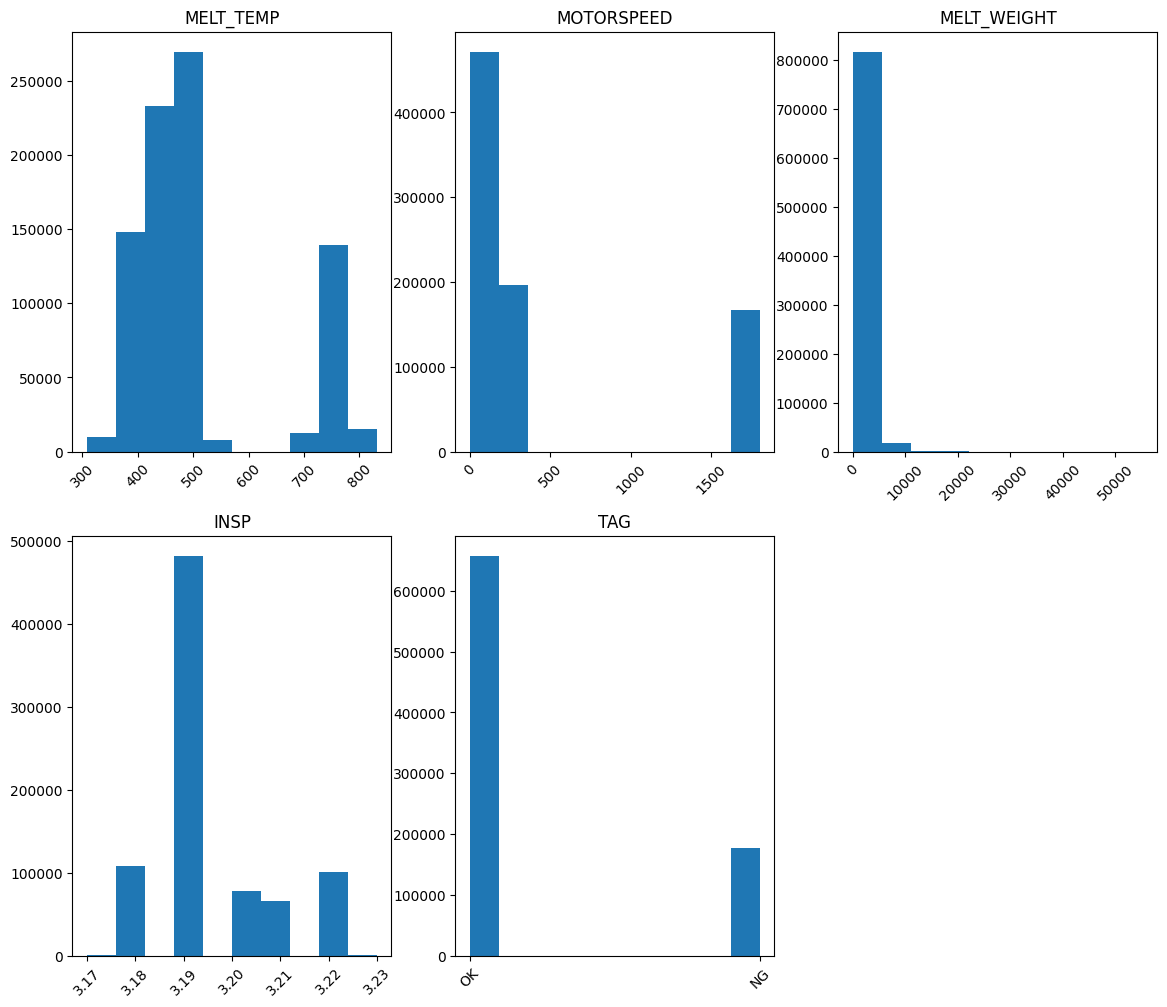

In [11]:
plt.figure(figsize=(14,12)) # 14(넓이) X 12(높이)로 설정
for i in range(len(col_name)): # 231 ~　235 까지의 그래프 내부의 서브플롯번호 탐색
    num = 231 + i # 서브플롯번호 생성
    plt.subplot(num) # 서브플롯번호 생성 및 지정
    plt.hist(df[col_name[i]]) # 각 변수의 값을 histogram 그래프에 입력 
    plt.xticks(rotation=45) # x축 눈금의 표시를 45도 기울이기
    plt.title(col_name[i]) # 그래프의 이름을 변수이름으로 지정
plt.show() # 그래프를 화면에 표시


histogram을 보면, 종속변수인 `TAG` 변수 `OK`/`NG`의 비율이 약 3.7:1(`OK`: 658133, `NG`: 177067)로<br>
불균형이 심하지 않다. 이는 후에 원본데이터를 일정비율로 학습(train), 검증(validation),<br>
테스트(test)값을 일정 비율로 나누어서 해결한다.<br>

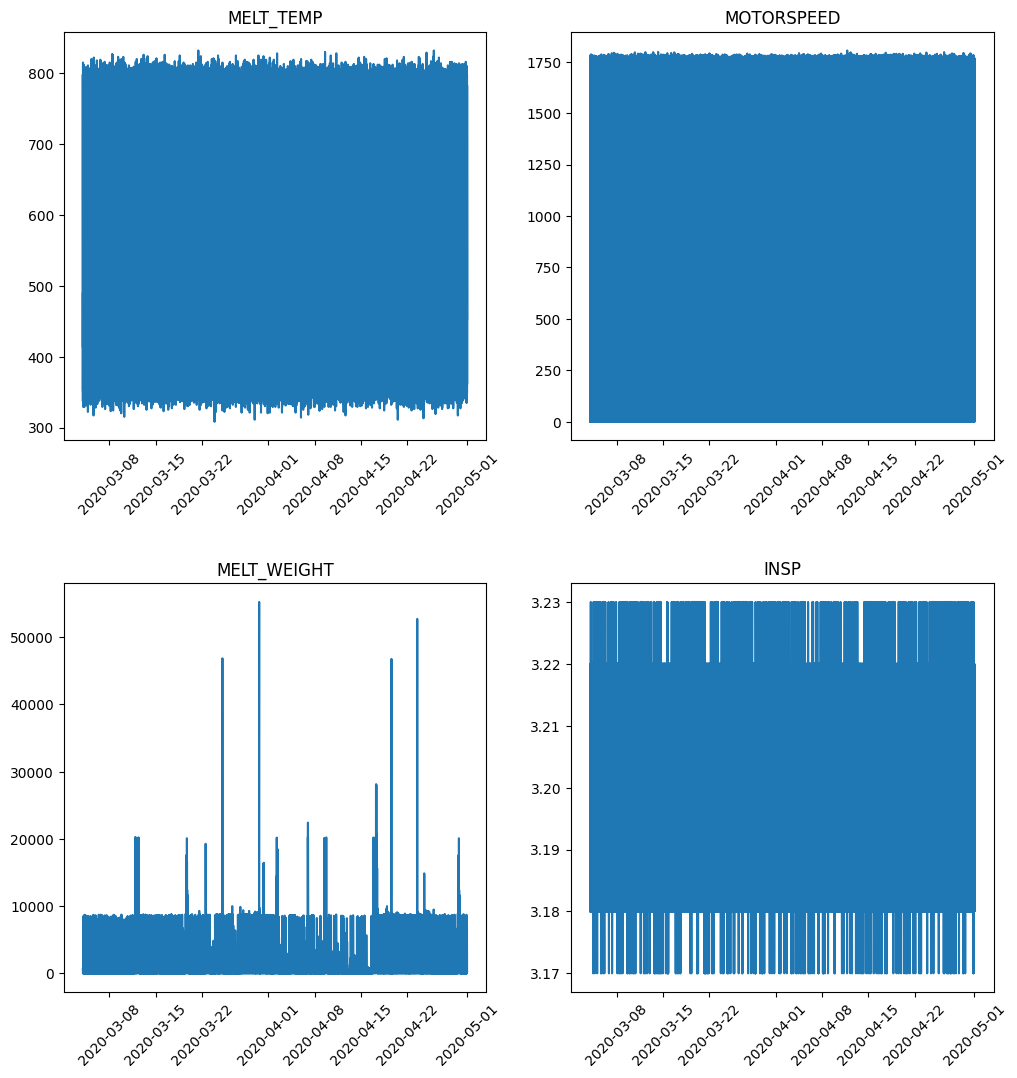

In [12]:
col_name = ['MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP']
plt.figure(figsize=(12,12))
for i in range(len(col_name)):
    num = 221 + i
    plt.subplot(num)
    plt.plot(df[col_name[i]])
    plt.xticks(rotation=45)
    plt.title(col_name[i])
plt.subplots_adjust(
    left=0.125
    ,bottom=0.1
    ,right=0.9
    ,top=0.9
    ,wspace=0.2
    ,hspace=0.35) #subplot들의 간격을 조정
plt.show()

소스코드 부분은 새로추가 및 변경된 부분만 주석을 추가하였으며<br>
그래프를 그린 결과 관측값이 너무 많아 그래프의 패턴을 살펴보기 어렵다.<br>
하지만 그래프의 상한선과 하한선은 어느정도 일치하며 `MELT_WEIGHT`변수에 몇몇 특이값이 보인다.<br>

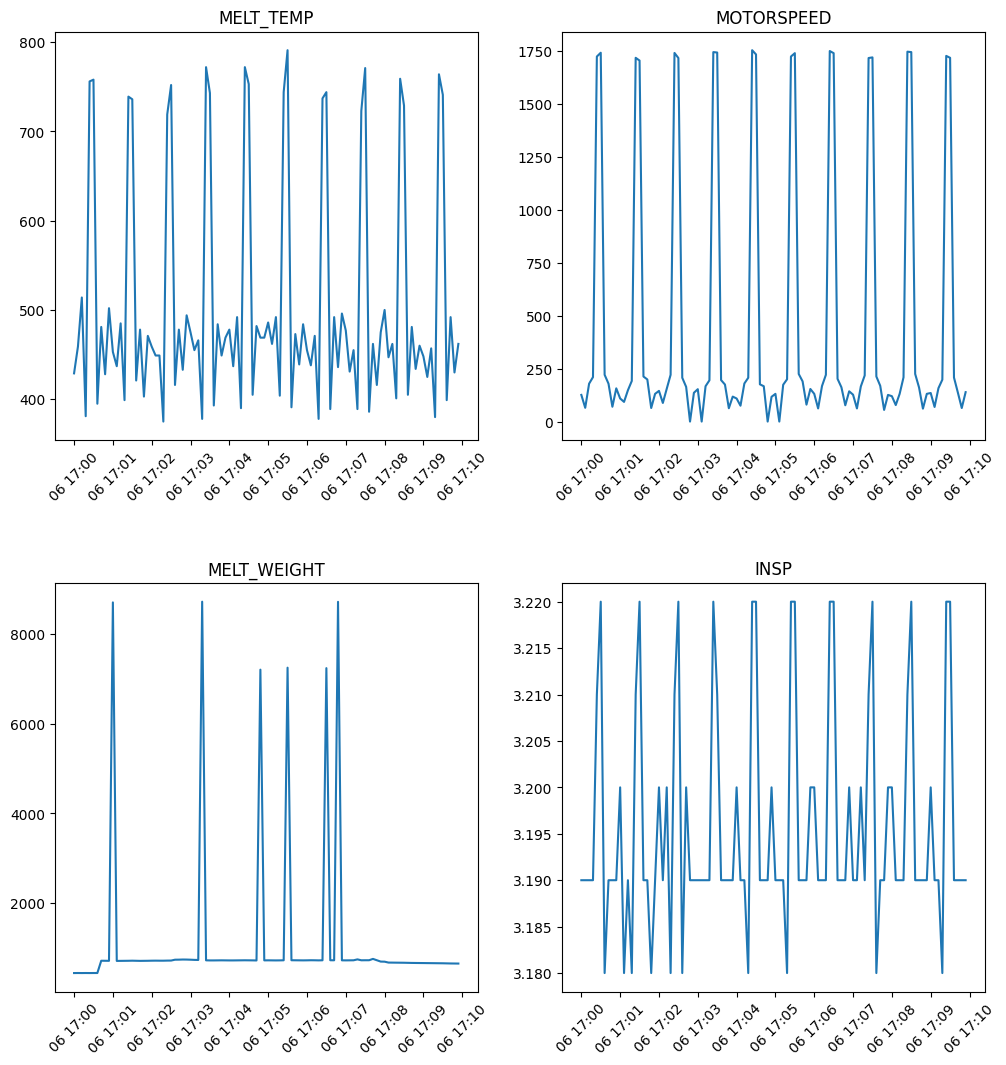

In [13]:
plt.figure(figsize=(12,12))
for i in range(len(col_name)):
    num = 221 + i
    plt.subplot(num)
    plt.plot(df[col_name[i]][39000:39100])
    plt.xticks(rotation=45)
    plt.title(col_name[i])
plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.35)
plt.show()

해당 데이터에서는 각 분(10개의 관측치)마다 패턴을 보이며 `MELT_WEIGHT`의 경우에는 몇몇<br>
특이값을 볼 수 있다. `MELT_WEIGHT` 변수의 데이터값을 확인하여 보았을 때, <br>
몇몇 2개의 이하의 데이터 (6초~12초)가 전후의 각 행의 차분의 절대값보다 월등히 높은것을 확인 할 수 있다. <br>
이는 연속적인 실측치가 기록되었다고 생각되기보다 PLC를 통해 입력된 값이 겹쳐서 기록 또는 오입력된 것으로 추정된다. <br>
위에서 언급했던 이 패턴은 추후에 window의 범위를 정할 시 활용할 예정이며 `MELT_WEIGHT`는 이상치 제거 및 보간을 할 예정이다.<br>

In [14]:
df_pre = df.copy() # 원본값 보존

# MELT_WEIGHT 이상치 보간
df_pre["MELT_WEIGHT_DIFF"] = df_pre["MELT_WEIGHT"].diff()
df_pre.loc[df_pre["MELT_WEIGHT_DIFF"].abs() > 80,"MELT_WEIGHT"] = np.NaN
df_pre["MELT_WEIGHT_PRE_P"] = df_pre["MELT_WEIGHT"].interpolate().astype(int)

# MElT_WEIGHT_PRE_P 의 이상치 보간
df_pre["MELT_WEIGHT_PRE_P_FOR2"] = df_pre["MELT_WEIGHT_PRE_P"]
df_pre["MELT_WEIGHT_PRE_DIFF"] = df_pre["MELT_WEIGHT_PRE_P_FOR2"].diff()
df_pre.loc[df_pre["MELT_WEIGHT_PRE_DIFF"].abs() > 80,"MELT_WEIGHT_PRE_P_FOR2"] = np.NaN
df_pre["MELT_WEIGHT_PRE_P2"] = df_pre["MELT_WEIGHT_PRE_P_FOR2"].interpolate().astype(int)

# TAG binary
df_pre["TAG_BINARY"] = 1
df_pre.loc[df_pre["TAG"] == "NG","TAG_BINARY"] = 0

# INSP 정규화
df_pre["S_INSP"] = (df_pre["INSP"] - df_pre["INSP"].mean()) / df_pre["INSP"].std()

first_idx = df_pre.head(1).index
# MOTORSPEED, MELT_WEIGHT, MELT_TEMP 증가량 컬럼 생성
df_pre["MOTORSPEED_DIFF"] = df_pre["MOTORSPEED"].diff()
df_pre.loc[first_idx,"MOTORSPEED_DIFF"] = 0
df_pre["MELT_WEIGHT_DIFF"] = df_pre["MELT_WEIGHT_PRE_P"].diff()
df_pre.loc[first_idx,"MELT_WEIGHT_DIFF"] = 0
df_pre["MELT_TEMP_DIFF"] = df_pre["MELT_TEMP"].diff()
df_pre.loc[first_idx,"MELT_TEMP_DIFF"] = 0

# MOTORSPEED, MELT_WEIGHT, MELT_TEMP 증가량의 증가량 컬럼 생성
df_pre["MOTORSPEED_DIFF2"] = df_pre["MOTORSPEED_DIFF"].diff()
df_pre.loc[first_idx,"MOTORSPEED_DIFF2"] = 0
df_pre["MELT_WEIGHT_DIFF2"] = df_pre["MELT_WEIGHT_DIFF"].diff()
df_pre.loc[first_idx,"MELT_WEIGHT_DIFF2"] = 0
df_pre["MELT_TEMP_DIFF2"] = df_pre["MELT_TEMP_DIFF"].diff()
df_pre.loc[first_idx,"MELT_TEMP_DIFF2"] = 0

In [15]:
df_pre.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,MELT_WEIGHT_DIFF,MELT_WEIGHT_PRE_P,MELT_WEIGHT_PRE_P_FOR2,MELT_WEIGHT_PRE_DIFF,MELT_WEIGHT_PRE_P2,TAG_BINARY,S_INSP,MOTORSPEED_DIFF,MELT_TEMP_DIFF,MOTORSPEED_DIFF2,MELT_WEIGHT_DIFF2,MELT_TEMP_DIFF2
STD_DT_SEC,,,,,,,,,,,,,,,,,,,
2020-03-04 00:00:00,2020-03-04,0,489,116,631.0,3.19,OK,0.0,631,631.0,NaN,631,1,-0.410480,0.0,0.0,0.0,0.0,0.0
2020-03-04 00:00:06,2020-03-04,1,433,78,609.0,3.19,OK,-22.0,609,609.0,-22.0,609,1,-0.410480,-38.0,-56.0,-38.0,-22.0,-56.0
2020-03-04 00:00:12,2020-03-04,2,464,154,608.0,3.19,OK,-1.0,608,608.0,-1.0,608,1,-0.410480,76.0,31.0,114.0,21.0,87.0
2020-03-04 00:00:18,2020-03-04,3,379,212,606.0,3.19,OK,-2.0,606,606.0,-2.0,606,1,-0.410480,58.0,-85.0,-18.0,-1.0,-116.0
2020-03-04 00:00:24,2020-03-04,4,798,1736,604.0,3.21,OK,-2.0,604,604.0,-2.0,604,1,1.281297,1524.0,419.0,1466.0,0.0,504.0


In [16]:
corr = df_pre.corr(method = 'pearson')
corr

C:\Users\Owner\AppData\Local\Temp\ipykernel_7968\68959252.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pre.corr(method = 'pearson')


,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,MELT_WEIGHT_DIFF,MELT_WEIGHT_PRE_P,MELT_WEIGHT_PRE_P_FOR2,MELT_WEIGHT_PRE_DIFF,MELT_WEIGHT_PRE_P2,TAG_BINARY,S_INSP,MOTORSPEED_DIFF,MELT_TEMP_DIFF,MOTORSPEED_DIFF2,MELT_WEIGHT_DIFF2,MELT_TEMP_DIFF2
NUM,1.000000e+00,0.000188,-0.000050,0.048692,-0.000524,5.200566e-07,0.069138,0.058010,5.200608e-07,0.062289,0.086698,-0.000524,-0.000002,-9.246249e-07,2.704290e-07,-1.525095e-08,-1.066162e-07
MELT_TEMP,1.884495e-04,1.000000,0.944929,-0.000623,0.916295,-5.815489e-04,0.000189,-0.000218,-5.815489e-04,0.000083,0.310586,0.916295,0.635701,6.679208e-01,1.102813e-01,2.154852e-04,2.208370e-01
MOTORSPEED,-5.035526e-05,0.944929,1.000000,-0.000373,0.887813,-1.594435e-04,0.000714,-0.000042,-1.594436e-04,0.000214,0.264693,0.887813,0.536329,5.101220e-01,-1.797538e-02,1.214280e-04,7.751523e-02
MELT_WEIGHT,4.869156e-02,-0.000623,-0.000373,1.000000,-0.000690,4.240329e-01,1.000000,1.000000,4.240329e-01,0.794957,-0.021556,-0.000690,-0.001138,-9.048807e-04,-6.551682e-04,-2.394580e-02,-5.341572e-04
INSP,-5.236376e-04,0.916295,0.887813,-0.000690,1.000000,-8.296464e-05,0.000111,-0.000384,-8.296464e-05,-0.000020,0.272580,1.000000,0.593174,6.053625e-01,9.620043e-02,7.171032e-04,1.884905e-01
MELT_WEIGHT_DIFF,5.200566e-07,-0.000582,-0.000159,0.424033,-0.000083,1.000000e+00,0.226479,-0.016944,1.000000e+00,0.000266,0.000808,-0.000083,-0.000379,-5.000473e-04,-3.826332e-04,5.691070e-01,-9.222164e-05
MELT_WEIGHT_PRE_P,6.913768e-02,0.000189,0.000714,1.000000,0.000111,2.264793e-01,1.000000,1.000000,2.264793e-01,0.723217,-0.010335,0.000111,-0.000104,-2.916132e-05,-5.041085e-05,-1.401737e-01,1.007712e-04
MELT_WEIGHT_PRE_P_FOR2,5.801000e-02,-0.000218,-0.000042,1.000000,-0.000384,-1.694350e-02,1.000000,1.000000,-1.694353e-02,1.000000,-0.028775,-0.000384,-0.000291,-3.308758e-04,-7.983882e-05,-3.529517e-02,-1.559940e-04
MELT_WEIGHT_PRE_DIFF,5.200608e-07,-0.000582,-0.000159,0.424033,-0.000083,1.000000e+00,0.226479,-0.016944,1.000000e+00,0.000266,0.000808,-0.000083,-0.000379,-5.000473e-04,-3.826332e-04,5.691070e-01,-9.222164e-05
MELT_WEIGHT_PRE_P2,6.228884e-02,0.000083,0.000214,0.794957,-0.000020,2.662950e-04,0.723217,1.000000,2.662951e-04,1.000000,-0.024762,-0.000020,-0.000334,-2.276328e-04,-1.751741e-04,-3.457595e-02,-1.068291e-04


종속변수인 `TAG`와 각 독립변수 간의 상관관계를 살펴보기 위하여 `corr()` 함수를 <br>
활용하여 상관분석을 진행한다. 상관분석은 연속형 변수로 측정된 변수 간의 선형 <br>
적 관계를 분석하는 기법이다. <br>

In [17]:
df1 = df_pre[['NUM', 'MELT_TEMP', 'MOTORSPEED', 
       'MELT_WEIGHT_DIFF', 'MELT_WEIGHT_PRE_P2', 
              'S_INSP',
        'MOTORSPEED_DIFF', 'MELT_TEMP_DIFF', 'MELT_WEIGHT_DIFF2'
        , 'MOTORSPEED_DIFF2', 'MELT_TEMP_DIFF2', 'TAG_BINARY']]

In [18]:
df1

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT_DIFF,MELT_WEIGHT_PRE_P2,S_INSP,MOTORSPEED_DIFF,MELT_TEMP_DIFF,MELT_WEIGHT_DIFF2,MOTORSPEED_DIFF2,MELT_TEMP_DIFF2,TAG_BINARY
STD_DT_SEC,,,,,,,,,,,,
2020-03-04 00:00:00,0,489,116,0.0,631,-0.410480,0.0,0.0,0.0,0.0,0.0,1
2020-03-04 00:00:06,1,433,78,-22.0,609,-0.410480,-38.0,-56.0,-22.0,-38.0,-56.0,1
2020-03-04 00:00:12,2,464,154,-1.0,608,-0.410480,76.0,31.0,21.0,114.0,87.0,1
2020-03-04 00:00:18,3,379,212,-2.0,606,-0.410480,58.0,-85.0,-1.0,-18.0,-116.0,1
2020-03-04 00:00:24,4,798,1736,-2.0,604,1.281297,1524.0,419.0,0.0,1466.0,504.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30 23:59:30,835195,755,1743,-1.0,318,1.281297,3.0,6.0,0.0,-1524.0,-352.0,1
2020-04-30 23:59:36,835196,385,206,-1.0,317,-0.410480,-1537.0,-370.0,0.0,-1540.0,-376.0,1
2020-04-30 23:59:42,835197,465,148,-1.0,316,0.435409,-58.0,80.0,0.0,1479.0,450.0,1


In [19]:
#정규화
scaler = preprocessing.MinMaxScaler()

scale_sc = scaler.fit_transform(df1)

X_values = scale_sc[:,:-1]
y_values = scale_sc[:,-1]

In [20]:
WINDOW_SIZE = 11

x_feature = np.array([ 
    X_values[i:i+WINDOW_SIZE]
    for i in np.arange(len(X_values) - WINDOW_SIZE)
])
y_label = np.array([ 
    np.array([y_values[i+WINDOW_SIZE-1]])
    for i in np.arange(len(y_values) - WINDOW_SIZE)
])

(
    train_feature
    , test_feature
    , train_label
    , test_label
) = train_test_split(x_feature, y_label, random_state=42, test_size=0.3, stratify=y_label)
(
    x_train
    , x_valid
    , y_train
    , y_valid
) = train_test_split(train_feature, train_label, random_state=42, test_size=0.3, stratify=train_label)

In [21]:
model = Sequential()
model.add(GRU(11, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation= 'tanh',
               return_sequences=False)
         )


model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 11)                792       
                                                                 
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 804
Trainable params: 804
Non-trainable params: 0
_________________________________________________________________


In [22]:
MODEL_PATH = "../data/model"
EARLY_STOPPING_PATIENCE = 3
BETA_1 = 0.9
LREARNING_RATE = 0.016

nadam_opt = Nadam(
    beta_1=BETA_1
    , learning_rate=LREARNING_RATE
)
model.compile(loss='binary_crossentropy', optimizer=nadam_opt, metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE)
filename = "/".join([MODEL_PATH, 'checkpoint.h5'])
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='auto')

In [23]:
history = model.fit(
    x_train
    , y_train
    , epochs=50
    , batch_size=256
    , validation_data=(x_valid, y_valid)
    , callbacks=[
        early_stop,
        checkpoint
    ]
)

Epoch 1/50
1599/1599 [==============================] - 11s 6ms/step - loss: 0.1551 - accuracy: 0.9346 - val_loss: 0.0977 - val_accuracy: 0.9620
Epoch 2/50
1599/1599 [==============================] - 10s 6ms/step - loss: 0.0869 - accuracy: 0.9669 - val_loss: 0.0728 - val_accuracy: 0.9711
Epoch 3/50
1599/1599 [==============================] - 11s 7ms/step - loss: 0.0634 - accuracy: 0.9767 - val_loss: 0.0800 - val_accuracy: 0.9673
Epoch 4/50
1599/1599 [==============================] - 11s 7ms/step - loss: 0.0516 - accuracy: 0.9797 - val_loss: 0.0460 - val_accuracy: 0.9809
Epoch 5/50
1599/1599 [==============================] - 11s 7ms/step - loss: 0.0457 - accuracy: 0.9816 - val_loss: 0.0377 - val_accuracy: 0.9847
Epoch 6/50
1599/1599 [==============================] - 11s 7ms/step - loss: 0.0420 - accuracy: 0.9831 - val_loss: 0.0395 - val_accuracy: 0.9835
Epoch 7/50
1599/1599 [==============================] - 11s 7ms/step - loss: 0.0412 - accuracy: 0.9835 - val_loss: 0.0397 - val_ac

In [24]:
model.load_weights(filename)
pred = model.predict(test_feature)

7830/7830 [==============================] - 15s 2ms/step


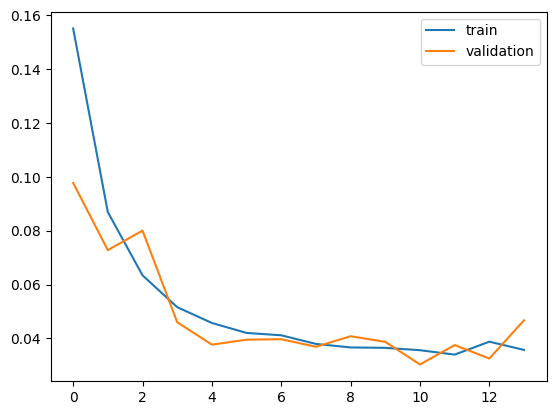

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

pred_df = pd.DataFrame(pred, columns=['TAG'])

pred_df.loc[pred_df['TAG'] >= 0.5,'TAG'] = 1
pred_df.loc[pred_df['TAG'] < 0.5,'TAG'] = 0

In [26]:
print(pred_df['TAG'].value_counts())

classify = confusion_matrix(test_label, pred_df)
print(classify)

1.0    198592
0.0     51965
Name: TAG, dtype: int64
[[ 50974   2146]
 [   991 196446]]


In [27]:
tn, fp, fn, tp = classify.ravel()

print("##########################################################")
p = precision_score(test_label, pred_df)
print(f"precision: {p:.4}")
r = recall_score(test_label, pred_df)
print(f"recall: {r:.4}")
f1 = f1_score(test_label, pred_df)
print(f"f1-score: {f1:.4}")
acc = accuracy_score(test_label, pred_df)
print(f"accuracy: {acc:.4}")
npv = tn / (tn + fn)
print(f"negative predict value: {npv:.4}")
print("###########################################################")

##########################################################
precision: 0.9892
recall: 0.995
f1-score: 0.9921
accuracy: 0.9875
negative predict value: 0.9809
###########################################################


In [28]:
def search_window(n_loop, X_values, y_values):
    
    best_score_list = []
    
    for i in range(n_loop):

        x_feature = np.array([ 
            X_values[i:i+WINDOW_SIZE]
            for i in np.arange(len(X_values) - WINDOW_SIZE)
        ])
        y_label = np.array([ 
            np.array([y_values[i+WINDOW_SIZE-1]])
            for i in np.arange(len(y_values) - WINDOW_SIZE)
        ])

        (
            train_feature
            , test_feature
            , train_label
            , test_label
        ) = train_test_split(x_feature, y_label, random_state=42, test_size=0.3, stratify=y_label)
        (
            x_train
            , x_valid
            , y_train
            , y_valid
        ) = train_test_split(train_feature, train_label, random_state=42, test_size=0.3, stratify=train_label)

        model = Sequential()
        model.add(GRU(11, 
                    input_shape=(train_feature.shape[1], train_feature.shape[2]),
                    activation= 'tanh',
                    return_sequences=False)
                )


        model.add(Dense(1, activation='sigmoid'))

        # 모델 훈련
        nadam_opt = Nadam(
            beta_1=BETA_1
            , learning_rate=LREARNING_RATE
        )
        model.compile(loss='binary_crossentropy', optimizer=nadam_opt, metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE)

        model.fit(
            x_train
            , y_train
            , epochs=50
            , batch_size=256
            , validation_data=(x_valid, y_valid)
            , callbacks=[
                early_stop
            ]
            , verbose=0
        )

        pred = model.predict(test_feature, verbose=0)
        pred_df = pd.DataFrame(pred, columns=['TAG'])

        pred_df.loc[pred_df['TAG'] >= 0.5,'TAG'] = 1
        pred_df.loc[pred_df['TAG'] < 0.5,'TAG'] = 0

        classify = confusion_matrix(test_label, pred_df)
        tn, fp, fn, tp = classify.ravel()

        p = precision_score(test_label, pred_df)
        r = recall_score(test_label, pred_df)
        f1 = f1_score(test_label, pred_df)
        acc = accuracy_score(test_label, pred_df)
        npv = tn / (tn + fn)
        best_score_list.append({
            "precision": p
            , "recall": r
            , "f1": f1
            , "accuracy": acc
            , "npv": npv
        })
    return pd.DataFrame(best_score_list)

In [29]:
score_df = search_window(50, X_values, y_values)

In [30]:
score_df

,precision,recall,f1,accuracy,npv
0,0.992352,0.991734,0.992043,0.987464,0.969348
1,0.996552,0.980839,0.988633,0.982228,0.932726
2,0.995748,0.986816,0.991262,0.986291,0.952579
3,0.995392,0.991258,0.993321,0.989495,0.968001
4,0.982614,0.991597,0.987085,0.979554,0.967670
5,0.983203,0.994393,0.988767,0.982196,0.978240
6,0.993438,0.990731,0.992083,0.987540,0.965895
7,0.979606,0.990179,0.984864,0.976017,0.961972
8,0.993109,0.985449,0.989264,0.983146,0.947422
9,0.996121,0.982009,0.989015,0.982810,0.936477


In [31]:
score_df.describe()

,precision,recall,f1,accuracy,npv
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.988298,0.988297,0.988275,0.981514,0.956953
std,0.006443,0.004923,0.003163,0.005021,0.017216
min,0.972561,0.976737,0.976100,0.962196,0.918721
25%,0.984864,0.985150,0.987168,0.979796,0.946492
50%,0.989858,0.988748,0.988735,0.982240,0.958564
75%,0.993657,0.991512,0.990113,0.984422,0.967919
max,0.996552,0.998030,0.993321,0.989495,0.991937


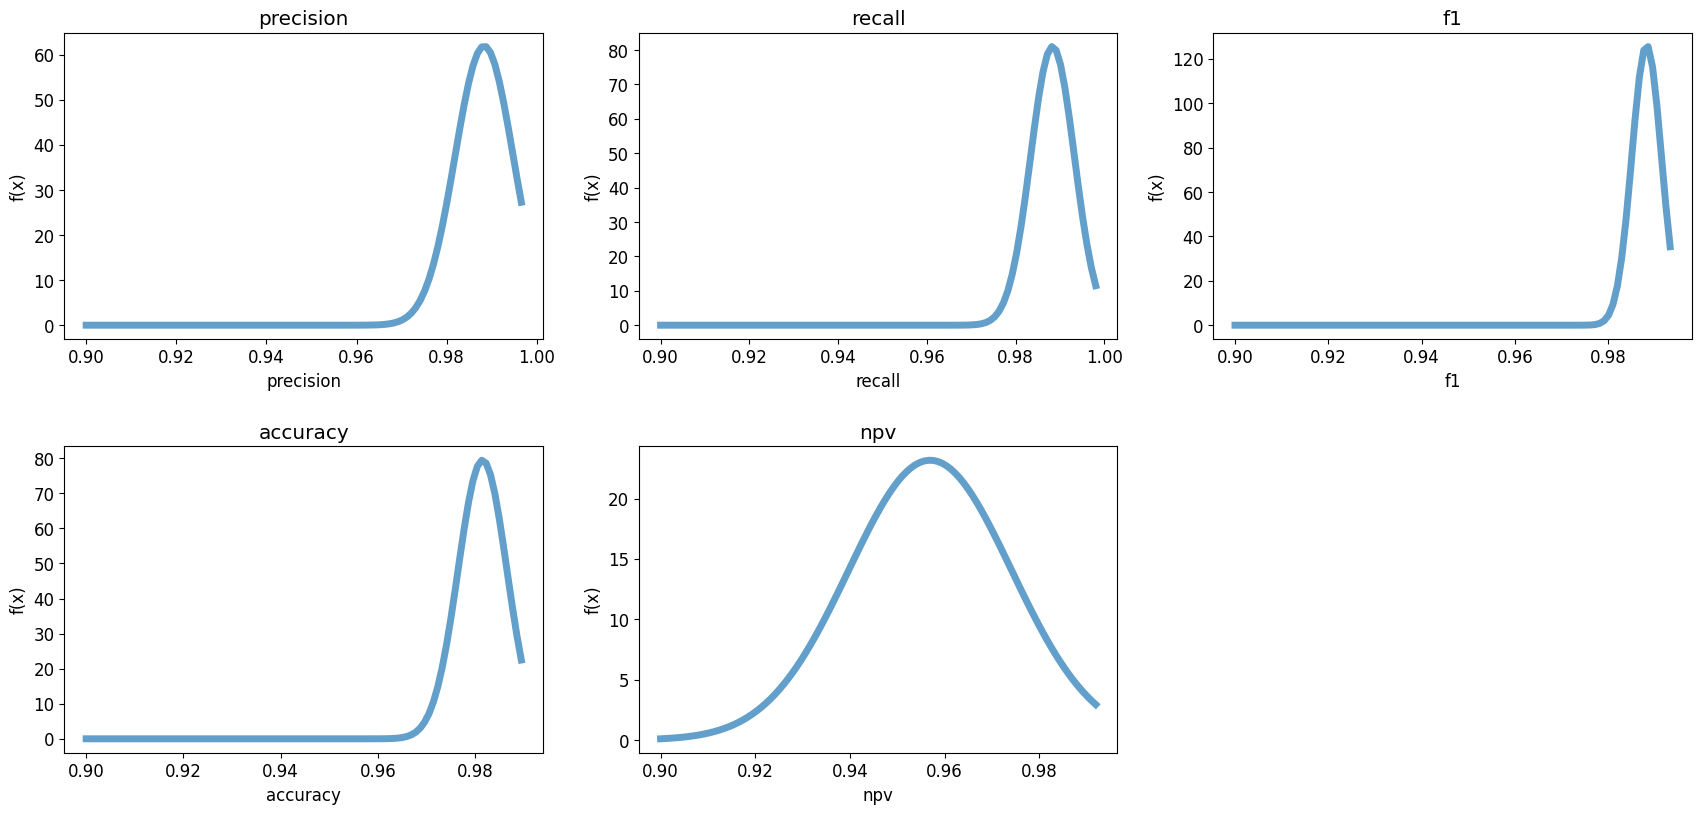

In [32]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (21,9) # 21(넓이) X 9(높이)로 설정
plt.rcParams['font.size'] = 12 # 폰트크기
plt.rcParams['lines.linewidth'] = 5 # 선의 넓이

g_name = ["precision", "recall", "f1", "accuracy", "npv"] # 각 score의 이름 리스트

for i, g in enumerate(g_name):
    mu1, sigma1 = score_df[g].mean(), score_df[g].std() # 평균과 표준편차
    x = np.linspace(0.9, score_df[g].max(), 100) # 0.9 ~ 1까지의 분포를 보여줌
    y1 = (1 / np.sqrt(2 * np.pi * sigma1**2)) * np.exp(-(x-mu1)**2 / (2 * sigma1**2)) # 확률밀도 계산
    num = 231 + i # 서브플롯번호 생성
    plt.subplot(num) # 서브플롯생성
    plt.plot(x, y1, alpha=0.7)  # 그래프에 데이터 입력

    plt.title(g) # 그래프 타이틀
    plt.xlabel(g) # x축의 라벨
    plt.ylabel('f(x)') # y축의 라벨
plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.35)
plt.show()

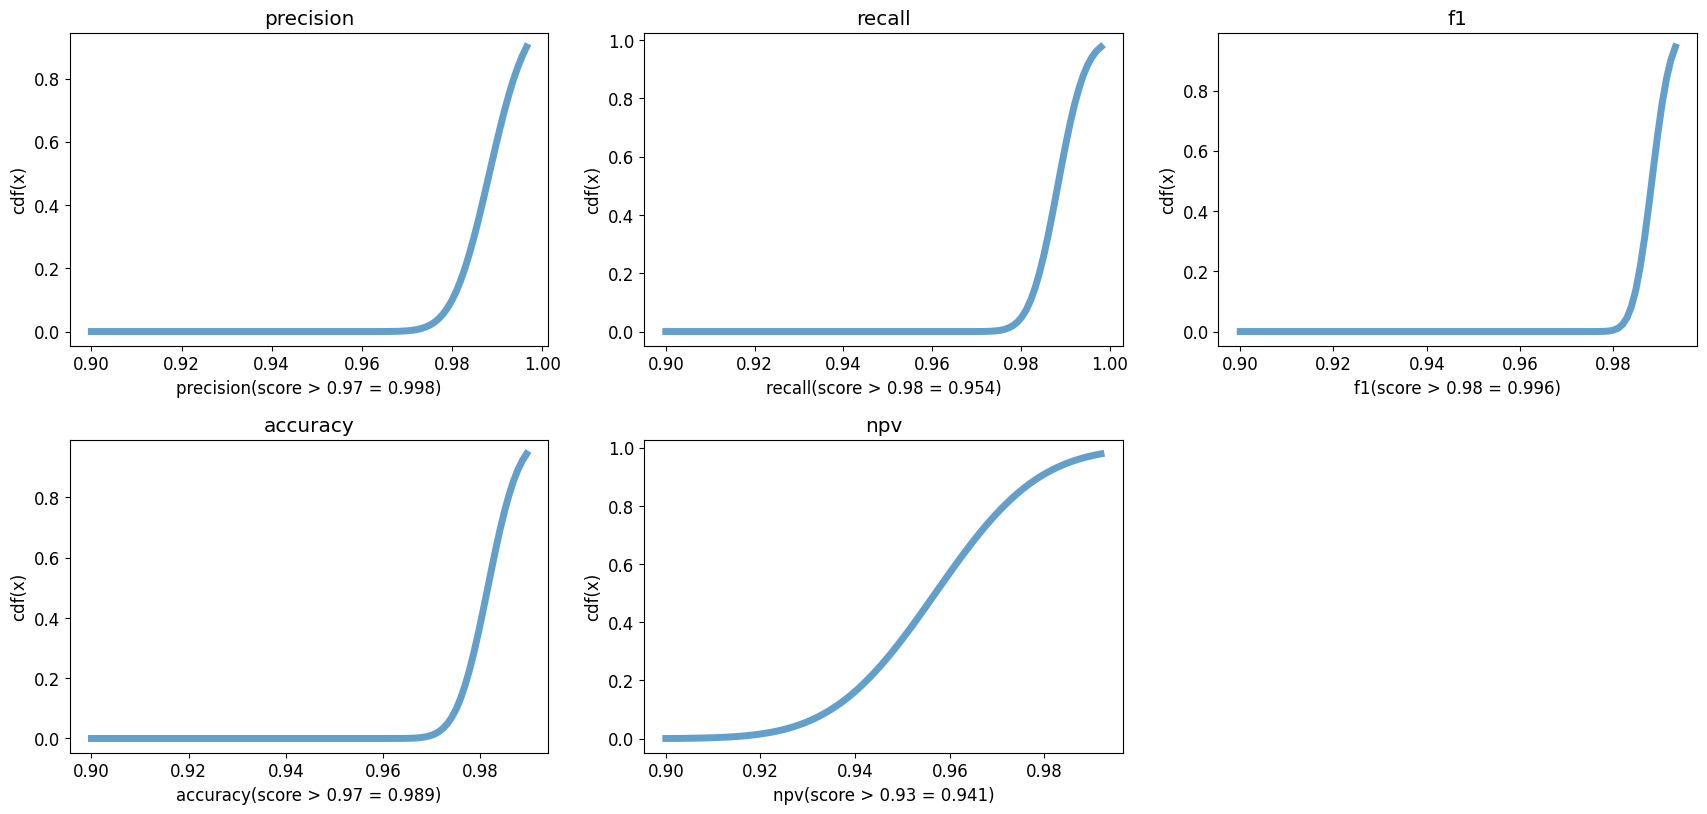

In [33]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (21,9) # 21(넓이) X 9(높이)로 설정
plt.rcParams['font.size'] = 12 # 폰트크기
plt.rcParams['lines.linewidth'] = 5 # 선의 넓이

for i, (g, cdf_from) in enumerate(zip(g_name,[0.97,0.98,0.98,0.97,0.93])):
    mu1, sigma1 = score_df[g].mean(), score_df[g].std() # 평균과 표준편차
    x = np.linspace(0.9, score_df[g].max(), 100) # 0.9 ~ 1까지의 분포를 보여줌
    y_cum = 0.5 * (1 + erf((x - mu1)/(np.sqrt(2 * sigma1**2)))) # 누적분포계산

    cdf_val = 1 - scipy.stats.norm(
                    loc = score_df[g].mean()
                    , scale = score_df[g].std()
                ).cdf(cdf_from) # 
    num = 231 + i # 서브플롯번호 생성
    plt.subplot(num) # 서브플롯생성
    plt.plot(x, y_cum, alpha=0.7)  # 그래프에 데이터 입력

    plt.title(g) # 그래프 타이틀
    plt.xlabel(f"{g}(score > {cdf_from} = {cdf_val:.3f})") # x축의 라벨
    plt.ylabel('cdf(x)')

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.3)
plt.show()